In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model
from utils.data_split import split_sequence_parallel
from utils.tcn import TCN, tcn_full_summary



# 不加这几句，则CONV 报错
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [2]:
data = pd.read_csv("./data/data_1009.csv", header=0,infer_datetime_format=True, engine='python')
data['Unnamed: 0']=pd.to_datetime(data['Unnamed: 0'])
data.set_index("Unnamed: 0",inplace=True)
'''
归一化
'''
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler3 = MinMaxScaler(feature_range=(0, 1))
scaler4 = MinMaxScaler(feature_range=(0, 1))
scaler5 = MinMaxScaler(feature_range=(0, 1))
scaler6 = MinMaxScaler(feature_range=(0, 1))
scaler7 = MinMaxScaler(feature_range=(0, 1))
scaler8 = MinMaxScaler(feature_range=(0, 1))
data_minmax = data.copy()
data_minmax['pm2.5']=scaler1.fit_transform(data_minmax['pm2.5'].values.reshape(-1,1))
data_minmax['DEWP']=scaler2.fit_transform(data_minmax['DEWP'].values.reshape(-1,1))
data_minmax['TEMP']=scaler3.fit_transform(data_minmax['TEMP'].values.reshape(-1,1))
data_minmax['PRES']=scaler4.fit_transform(data_minmax['PRES'].values.reshape(-1,1))
data_minmax['cbwd_NE']=scaler5.fit_transform(data_minmax['cbwd_NE'].values.reshape(-1,1))
data_minmax['cbwd_NW']=scaler6.fit_transform(data_minmax['cbwd_NW'].values.reshape(-1,1))
data_minmax['cbwd_SE']=scaler7.fit_transform(data_minmax['cbwd_SE'].values.reshape(-1,1))
data_minmax['cbwd_cv']=scaler7.fit_transform(data_minmax['cbwd_cv'].values.reshape(-1,1))

In [3]:
'''
取一年的时间，10个月做训练和验证，2个月做测试
'''
cast1 = 35064
cast2 = -1464
data_train = data_minmax[cast1:cast2]
data_test = data_minmax[cast2:] 
data_train.shape,data_test.shape

((7296, 8), (1464, 8))

In [4]:
data_train = np.array(data_train)
data_test = np.array(data_test)
data_train.shape,data_test.shape

((7296, 8), (1464, 8))

In [5]:
sw_width = 21
pred_length = 12
verbose_set = 2
X, y, features = split_sequence_parallel(data_train,sw_width,pred_length)
test_x,test_y,test_features = split_sequence_parallel(data_test,sw_width,pred_length)

In [34]:
def TCN_model():
    
    ip = Input(shape=(sw_width,features))

    x = TCN(return_sequences=False,nb_filters=200,kernel_size=4)(ip)

    
    out = Dense(pred_length)(x)
    model = Model(ip, out)
    model.summary()


    return model

In [35]:
TCN_model1 = TCN_model()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 21, 8)]           0         
_________________________________________________________________
tcn_2 (TCN)                  (None, 200)               1770600   
_________________________________________________________________
dense_2 (Dense)              (None, 12)                2412      
Total params: 1,773,012
Trainable params: 1,773,012
Non-trainable params: 0
_________________________________________________________________


In [36]:
import time
from keras import backend as K
from keras.callbacks import ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
# from utils.lr_process import lr_schedule
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# lr_scheduler = LearningRateScheduler(lr_schedule)
# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=5,
#                                min_lr=0.5e-6)

filepath = "D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\\12hourweights\TCN_model_weights_best.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)
callbacks_list = [checkpoint]

In [37]:
starttime=time.time()
TCN_model1.compile(loss=root_mean_squared_error, optimizer='adam')
history1 = TCN_model1.fit(X,y,validation_split=0.25,epochs=60, batch_size=32,callbacks=callbacks_list, verbose=2)
endtime=time.time()
dtime=endtime-starttime
print("程序运行时间为：%.8s s" % dtime)  #时间显示到微秒

Train on 5448 samples, validate on 1816 samples
Epoch 1/60

Epoch 00001: val_loss improved from inf to 0.05958, saving model to D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\12hourweights\TCN_model_weights_best.hdf5
5448/5448 - 6s - loss: 0.1516 - val_loss: 0.0596
Epoch 2/60

Epoch 00002: val_loss improved from 0.05958 to 0.05433, saving model to D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\12hourweights\TCN_model_weights_best.hdf5
5448/5448 - 3s - loss: 0.0621 - val_loss: 0.0543
Epoch 3/60

Epoch 00003: val_loss improved from 0.05433 to 0.05204, saving model to D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\12hourweights\TCN_model_weights_best.hdf5
5448/5448 - 3s - loss: 0.0568 - val_loss: 0.0520
Epoch 4/60

Epoch 00004: val_loss improved from 0.05204 to 0.05008, saving model to D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\12hourweights\TCN_model_weights_best.hdf5
5448/5448 - 3s - loss: 0.0551 - val_loss: 0.0501
Epoch 5/60

Epoch 00005: val_loss improved from 0.05008 to 0.04866, saving model to D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\12hourweights\TCN

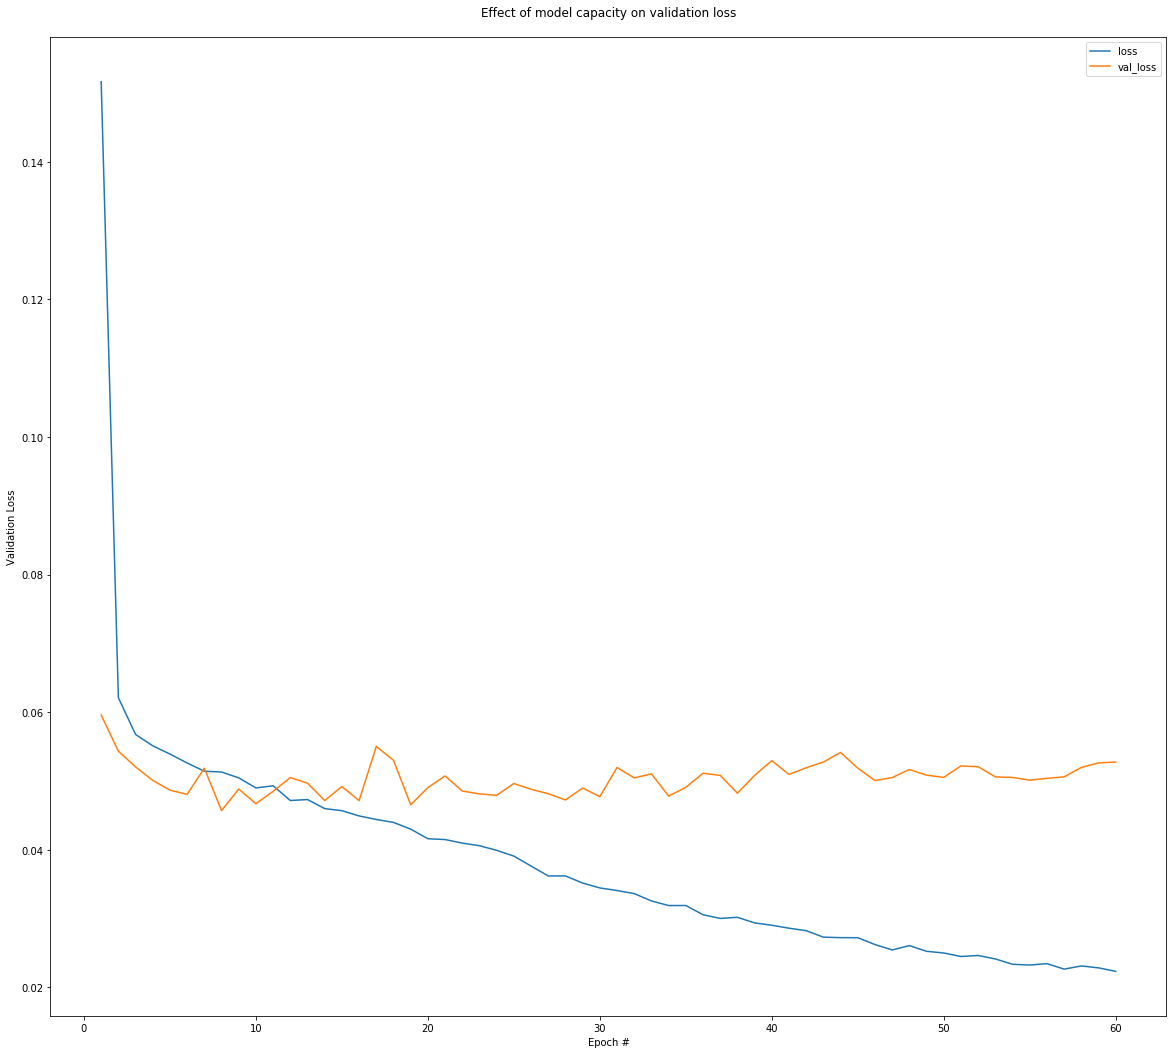

In [38]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = np.arange(60) + 1
plt.figure(figsize=(20,18))
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title("Effect of model capacity on validation loss\n")
plt.xlabel('Epoch #')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

In [39]:
TCN_model1.load_weights(filepath)

In [40]:
predict=TCN_model1.predict(test_x)
predict=scaler1.inverse_transform(predict.reshape(predict.shape[0],predict.shape[1]))

In [41]:
tf.sqrt(tf.losses.mean_squared_error(predict,scaler1.inverse_transform(test_y))).numpy().mean()

55.50858640971194

In [42]:
filepath = "D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\\12hourweights\TCN_model_weights_best.hdf5"
TCN_model1.load_weights(filepath)

In [43]:
predict=TCN_model1.predict(test_x)
predict=scaler1.inverse_transform(predict.reshape(predict.shape[0],predict.shape[1]))

In [44]:
tf.sqrt(tf.losses.mean_squared_error(predict,scaler1.inverse_transform(test_y))).numpy().mean()

55.50858640971194

In [45]:
tf.losses.mae(predict,scaler1.inverse_transform(test_y)).numpy().mean()

47.32186968298196

In [15]:
for i in range(7):
    loss1 = tf.sqrt(tf.losses.mean_squared_error(predict[:,i],scaler1.inverse_transform(test_y)[:,i])).numpy()
    print(i,":",loss1)

0 : 26.633108285699183
1 : 41.230978098839515
2 : 52.434434319652006
3 : 59.165803514474696
4 : 68.60176551861699
5 : 74.1741070389198
6 : 78.67280584903567


In [16]:
for i in range(7):
    loss1 = tf.sqrt(tf.losses.mae(predict[:,i],scaler1.inverse_transform(test_y)[:,i])).numpy()
    print(i,":",loss1)

0 : 4.08006519988547
1 : 5.128589926666524
2 : 5.758342817102427
3 : 6.104568136804925
4 : 6.717375248284704
5 : 7.104174047301022
6 : 7.272749121091096
